Analysing the check-in and check-out times of car to estimate parking space availability

In [ ]:
filename = "treas_parking_meters_loc_datasd.csv"

import pandas as pd
# Replace 'your_csv_file.csv' with the path to your actual CSV file
df_ori = pd.read_csv(filename)
# print(df_ori.info)
df_loc = df_ori.iloc[:,[3,7,8]]
print(df_loc)

def is_convertible_to_float_lat(s):
    # return False
    try:
        float(s)
        return True and ( float(s) > 27 and float(s) < 37 )
    # except ValueError:
    except:
        return False


def is_convertible_to_float_lng(s):
    # return False
    try:
        float(s)
        return True and ( float(s) > -126 and float(s) < -109 )
    # except ValueError:
    except:
        return False

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def criteria1_fn(s):
    for items in months:
        if( s.find(items) != -1  ):
            return False
        if(len(s.strip()) > 10):
            return False
    return True

criteria1 = df_loc['pole'].apply(criteria1_fn)
criteria2 = df_loc['lat'].apply(is_convertible_to_float_lat)
criteria3 = df_loc['lng'].apply(is_convertible_to_float_lng)

df_loc = df_loc[criteria1]
df_loc = df_loc[criteria2]
df_loc = df_loc[criteria3]

# print(df_loc)

min_lat = min(df_loc['lat'])
min_lng = min(df_loc['lng'])

# print(min_lat, min_lng)

import matplotlib.pyplot as plt

def scatter_plot_columns(df, x_column_name, y_column_name):
    # Extracting data from the specified columns
    x_data = df[x_column_name]
    y_data = df[y_column_name]

    # Plotting the data as a scatter plot
    plt.scatter(x_data, y_data, s=2)
    plt.xlabel(x_column_name)
    plt.ylabel(y_column_name)
    plt.title(f'Scatter Plot of {x_column_name} vs {y_column_name}')
    plt.grid(True)
    plt.show()

# df_loc['lng'] = -abs(df_loc['lng'])
# df_loc['lat'] = abs(df_loc['lat'])

df_loc = df_loc.drop_duplicates()

# scatter_plot_columns(df_loc,'lng','lat')
# print(df_loc)

import pickle

filename = "treas_parking_payments_2019_datasd.csv"
df_payments = pd.read_csv(filename)

# with open('payments.pickle', 'wb') as f:
#     pickle.dump(df_payments, f)

# df_payments = []

# with open('payments.pickle', 'rb') as f:
#     df_payments = pickle.load(f)

print(df_payments)

In [ ]:
df_pay = df_payments.iloc[:,[0,2,3]]
df_pay
df_pay = df_pay[df_pay['pole_id'].apply(criteria1_fn)]
df_pay

In [ ]:
# df_pay['date_trans_start'].str.split(' ')
df_pay[['day_trans_start', 'time_trans_start']] = df_pay['date_trans_start'].str.split(' ', n=1, expand=True)

# Dropping the original 'Full Name' column if needed
df_pay.drop('date_trans_start', axis=1, inplace=True)
df_pay

In [ ]:
df_pay[['day_meter_expire', 'time_meter_expire']] = df_pay['date_meter_expire'].str.split(' ', n=1, expand=True)

# Dropping the original 'Full Name' column if needed
df_pay.drop('date_meter_expire', axis=1, inplace=True)
df_pay

In [ ]:
from datetime import datetime
def convert_to_24h(time_str):
  # Parse the time string into a datetime object
  time_obj = datetime.strptime(time_str, '%I:%M:%S %p')
  # Convert to 24-hour format and format as string
  return time_obj.strftime('%H:%M:%S')

# Apply the conversion function to the 'time' column using apply
df_pay['time_meter_expire'] = df_pay['time_meter_expire'].apply(convert_to_24h)
df_pay

In [9]:
# with open('df_pay_pole_d_start_end_separate', 'wb') as f:
#     pickle.dump(df_pay, f)
import pickle
import pandas as pd
# df_pay = []
# with open('df_pay_pole_d_start_end_separate', 'rb') as f:
#     df_pay = pickle.load(f)

In [ ]:
df_pay_short = df_pay[:]
def getHR(s):
    return s.split(':')[0]
df_pay_short['time_trans_start'] = df_pay_short['time_trans_start'].apply(getHR)
df_pay_short['time_meter_expire'] = df_pay_short['time_meter_expire'].apply(getHR)

df_pay_short.drop('day_trans_start', axis=1, inplace=True)
df_pay_short.drop('day_meter_expire', axis=1, inplace=True)

df_pay_short


In [11]:
# merged_df = df_pay_short.groupby('pole_id')['time_trans_start'].apply(lambda x: ','.join(x)).apply(lambda x: x.split(',')).reset_index()
# # merged_df
# merged_df_1 = df_pay_short.groupby('pole_id')['time_trans_start'].apply(lambda x: ','.join(x)).apply(lambda x: x.split(',')).reset_index()
# merged_df_1
merged_df = df_pay_short.groupby('pole_id').agg({'time_trans_start': ','.join, 'time_meter_expire': ','.join}).reset_index()

In [12]:
merged_df['time_trans_start'] = merged_df['time_trans_start'].apply(lambda x : x.split(','))
merged_df['time_meter_expire'] = merged_df['time_meter_expire'].apply(lambda x : x.split(','))
merged_df_new = merged_df.copy()

In [ ]:
from collections import Counter
merged_df_new['time_trans_start'] = merged_df_new['time_trans_start'].apply(lambda x : Counter(x))
merged_df_new['time_meter_expire'] = merged_df_new['time_meter_expire'].apply(lambda x : Counter(x))
merged_df_new

In [14]:
df_car_status = merged_df_new.copy()

In [15]:
# Add missing keys with zero values to each dictionary
specified_keys = list(range(24))
df_car_status['time_trans_start'] = [dict(diff, **{str(key): diff.get(str(key), 0) for key in specified_keys}) for diff in df_car_status['time_trans_start']]
df_car_status['time_meter_expire'] = [dict(diff, **{str(key): diff.get(str(key), 0) for key in specified_keys}) for diff in df_car_status['time_meter_expire']]

In [ ]:
df_car_status['data_diff'] = [{key: df_car_status['time_trans_start'][i][key] - df_car_status['time_meter_expire'][i].get(key, 0) for key in df_car_status['time_trans_start'][i]} for i in range(len(df_car_status))]
df_car_status

In [17]:
def transform_dict(diff_dict):
    # Convert keys to integers
    diff_dict_int = {int(k): v for k, v in diff_dict.items()}
    
    # Find the minimum key
    min_key = min(diff_dict_int.keys())
    # max_key = max(diff_dict_int.keys())
    
    # Initialize the value to add
    add_value = diff_dict_int[min_key]
   
    
    # Iterate through the sorted keys (excluding the minimum key)
    # for key in sorted(diff_dict_int.keys())[1:]:

    for key in sorted(diff_dict_int.keys())[:]:
        # Add the value of the current key to the value of the previous key
        diff_dict_int[key] += add_value
        # Update the value to add for the next key
        add_value = diff_dict_int[key]
    
    # Convert keys back to strings and return the modified dictionary
    return {str(k): v for k, v in diff_dict_int.items()}

# Apply the transformation function to each dictionary in the data_diff column
df_car_status['data_diff'] = df_car_status['data_diff'].apply(transform_dict)

In [ ]:
df_car_status

In [19]:
min_values = df_car_status['data_diff'].apply(lambda x: min(x.values()))

# Add the absolute value of the minimum value to each value in the dictionary
df_car_status['data_diff'] = [{key: int(value) + abs(int(min_value)) for key, value in diff.items()} for diff, min_value in zip(df_car_status['data_diff'], min_values)]

In [20]:
# Compute the sum of all values in each dictionary and divide each value by the sum

def normalize_dictionary_values(d):
    total = sum(d.values())
    return {key: round(value / total , 4) for key, value in d.items()}
df_car_status['data_diff'] = df_car_status['data_diff'].apply(normalize_dictionary_values)

In [ ]:
df_car_status

In [22]:
df_car_status['data_diff'][405]

{'11': 0.0629,
 '7': 0.0584,
 '13': 0.0482,
 '9': 0.0584,
 '17': 0.0298,
 '15': 0.0513,
 '12': 0.0599,
 '10': 0.0614,
 '8': 0.0584,
 '14': 0.049,
 '16': 0.0531,
 '5': 0.0584,
 '6': 0.0584,
 '19': 0.0,
 '20': 0.0,
 '0': 0.0584,
 '1': 0.0584,
 '2': 0.0584,
 '3': 0.0584,
 '4': 0.0584,
 '18': 0.0,
 '21': 0.0,
 '22': 0.0,
 '23': 0.0}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


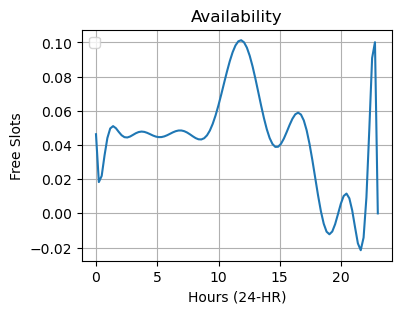

In [23]:
import matplotlib.pyplot as plt
import numpy as np
# Extract keys and values from the data_diff column
diff_dict = df_car_status['data_diff'][835]

# Sort dictionary items by integer keys
sorted_diff_dict = {k: diff_dict[k] for k in sorted(diff_dict, key=int)}

# # Plotting
# plt.figure(figsize=(4,3))
# plt.bar(sorted_diff_dict.keys(), sorted_diff_dict.values())
# plt.xlabel('Keys')
# plt.ylabel('Values')
# plt.title('Data Difference')
# plt.show()

# Convert keys and values to arrays for plotting
x = np.array(list(sorted_diff_dict.keys()), dtype=int)
y = np.array(list(sorted_diff_dict.values()))

# Fit a polynomial curve
coefficients = np.polyfit(x, y, 15)  # Choose the degree of the polynomial (e.g., 3 for cubic)
curve_x = np.linspace(min(x), max(x), 100)
curve_y = np.polyval(coefficients, curve_x)

# Plotting
plt.figure(figsize=(4,3))
# plt.plot(curve_x, curve_y, label='Fitting Curve')
plt.plot(curve_x, curve_y)
# plt.scatter(x, y, color='red', label='Data Points')
plt.xlabel('Hours (24-HR)')
plt.ylabel('Free Slots')
plt.title('Availability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_loc.reset_index(drop=True, inplace=True)
df_loc

In [ ]:
df_loc.rename(columns={'pole': 'pole_id'}, inplace=True)
all_data_df = pd.merge(df_car_status, df_loc, on='pole_id', how='inner')
all_data_df

In [26]:
import pandas as pd

def print_df_to_csv(df, filename):
    """
    Print DataFrame to a CSV file.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to print.
        filename (str): The name of the CSV file to create.
    
    Returns:
        None
    """
    df.to_csv(filename, index=False)
    print(f"DataFrame has been printed to '{filename}'")

In [27]:
def add_prefix(column, prefix):
    return column.apply(lambda x: prefix + str(x))
all_data_df['pole_id'] = add_prefix(all_data_df['pole_id'],' ')
print_df_to_csv(all_data_df, 'output.csv')

DataFrame has been printed to 'output.csv'


In [ ]:
all_data_df_new = all_data_df.copy()
all_data_df_new.drop(columns=['time_trans_start', 'time_meter_expire'], inplace=True)
all_data_df_new

In [29]:
print_df_to_csv(all_data_df_new, 'car_time_loc.csv')

DataFrame has been printed to 'car_time_loc.csv'


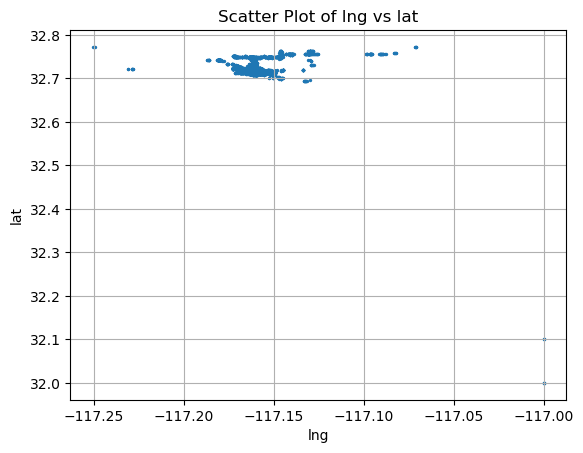

      pole_id        lat         lng
0      1-1004  32.715904 -117.163929
1      1-1006  32.716037 -117.163930
2      1-1008  32.716169 -117.163931
3      1-1020  32.717890 -117.161278
4      1-1310  32.719024 -117.163951
...       ...        ...         ...
4755  WUV-115  32.748172 -117.163305
4756  WUV-116  32.748326 -117.163266
4757  WUV-117  32.748172 -117.163231
4758  WUV-118  32.748326 -117.163193
4759  WUV-119  32.748173 -117.163158

[4760 rows x 3 columns]


In [30]:
scatter_plot_columns(df_loc,'lng','lat')
print(df_loc)

In [31]:
import matplotlib.pyplot as plt

def scatter_plot_columns_range(df, x_column_name, y_column_name, x_min=None, x_max=None, y_min=None, y_max=None, dpi=100, save_path=None, dot_size=2):
    # Extracting data from the specified columns
    x_data = df[x_column_name]
    y_data = df[y_column_name]

    # Plotting the data as a scatter plot
    plt.scatter(x_data, y_data, s=dot_size)
    plt.xlabel(x_column_name)
    plt.ylabel(y_column_name)
    plt.title(f'Scatter Plot of {x_column_name} vs {y_column_name}')
    plt.grid(True)
    
    # Set range for x-axis if provided
    if x_min is not None and x_max is not None:
        plt.xlim(x_min, x_max)
    
    # Set range for y-axis if provided
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    
    # Save figure with specified DPI if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi)
        plt.show()
    else:
        plt.show()

# Example usage:
# scatter_plot_columns(df, 'x_column', 'y_column', x_min=0, x_max=10, y_min=0, y_max=20, dpi=300, save_path='scatter_plot.png')


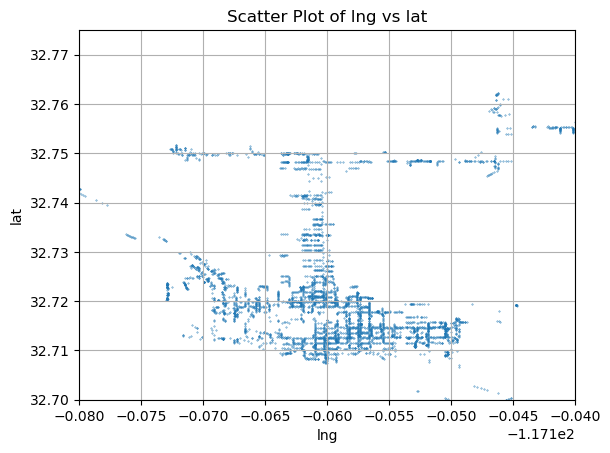

In [32]:
scatter_plot_columns_range(df_loc, 'lng', 'lat', x_min=-117.18, x_max=-117.14, y_min=32.7, y_max=32.775,dpi=1200,save_path='fig.png', dot_size=0.1 )

In [33]:
def aggregate_values_by_group(df, group_size=4):
    """
    Aggregate values in a DataFrame column containing dictionaries.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the dictionary column.
        group_size (int): The number of keys to group together.
    
    Returns:
        pandas.DataFrame: The DataFrame with aggregated values.
    """
    # Create a new DataFrame to store aggregated values
    aggregated_df = pd.DataFrame()

    # Iterate over each row in the original DataFrame
    for index, row in df.iterrows():
        # Get the dictionary from the row
        dictionary = row[df.columns[0]]
        # Create a new dictionary to store aggregated values
        aggregated_values = {}
        # Group the values by the keys and sum them for each group
        for i in range(0, len(dictionary), group_size):
            keys_subset = [str(j) for j in range(i, min(i + group_size, len(dictionary)))]
            subset_sum = sum(dictionary.get(key, 0) for key in keys_subset)
            aggregated_values[f"{i//group_size + 1}th"] = subset_sum
        # Append the aggregated dictionary to the new DataFrame
        aggregated_df = aggregated_df.append(aggregated_values, ignore_index=True)

    return aggregated_df

In [ ]:
all_data_df_new

In [35]:
def aggregate_values_by_group(dictionary, group_size):
    """
    Aggregate values in a dictionary by groups of a specified size.

    Parameters:
        dictionary (dict): The dictionary containing the values to be aggregated.
        group_size (int): The size of each group.

    Returns:
        dict: The dictionary containing the aggregated values.
    """
    
    aggregated_dict = {}
    for i in range(0, len(dictionary), group_size):
        group_values = {key: dictionary[key] for key in list(dictionary.keys())[i:i+group_size]}
        aggregated_value = sum(group_values.values())  # Sum the values for the group
        # aggregated_dict[f"{i//group_size + 1}th"] = round(aggregated_value,5)
        aggregated_dict[f"{i}-{i+group_size} HRS"] = round(aggregated_value,5)
    return aggregated_dict


In [ ]:
all_data_df_new1 = all_data_df_new.copy()
all_data_df_new1['data_diff_aggregated'] = all_data_df_new1['data_diff'].apply(lambda x: aggregate_values_by_group(x, group_size=6))
all_data_df_new1

In [37]:
all_data_df_new1['data_diff_aggregated'][99]

{'0-6 HRS': 0.492, '6-12 HRS': 0.312, '12-18 HRS': 0.1307, '18-24 HRS': 0.0655}

In [ ]:
all_data_df_new2 = all_data_df_new1.copy()
all_data_df_new2.drop(['data_diff'], axis=1, inplace=True)
all_data_df_new2

In [ ]:
import pandas as pd
all_data_df_new3 = all_data_df_new2.copy()
all_data_df_new3 = all_data_df_new3.join(all_data_df_new3['data_diff_aggregated'].apply(lambda x: pd.Series(x)))
all_data_df_new3.drop('data_diff_aggregated', axis=1, inplace=True)
all_data_df_new3

In [40]:
# with open('all_data_df_new.pickle', 'wb') as f:
#     pickle.dump(all_data_df_new, f)

# with open('all_data_df_new1.pickle', 'wb') as f:
#     pickle.dump(all_data_df_new1, f)

# with open('all_data_df_new2.pickle', 'wb') as f:
#     pickle.dump(all_data_df_new2, f)

# with open('all_data_df_new3.pickle', 'wb') as f:
#     pickle.dump(all_data_df_new3, f)

In [41]:
# import pickle
# all_data_df_new=[]
# all_data_df_new1=[]
# all_data_df_new2=[]
# all_data_df_new3=[]
# with open('all_data_df_new.pickle', 'rb') as f:
#     all_data_df_new = pickle.load(f)

# with open('all_data_df_new1.pickle', 'rb') as f:
#     all_data_df_new1 = pickle.load(f)

# with open('all_data_df_new2.pickle', 'rb') as f:
#     all_data_df_new2 = pickle.load(f)

# with open('all_data_df_new3.pickle', 'rb') as f:
#     all_data_df_new3 = pickle.load(f)

In [ ]:
all_data_df_new3

In [43]:
# scatter_plot_columns_range(df_loc, 'lng', 'lat', x_min=-117.18, x_max=-117.14, y_min=32.7, y_max=32.775,dpi=1200,save_path='fig.png', dot_size=0.1 )

In [47]:
import folium
import numpy as np
import matplotlib.colors as mcolors

def get_fill_color(my_list,value):
    """
    Generate fill color based on a number between 0.1 and 0.5.
    The color varies linearly from orange (0.1) to blue (0.5),
    with green for the highest values.
    """
    # Ensure value is within the valid range (0.1 to 0.5)
    # min_val = min(my_list)
    # max_val = max(my_list)

    min_val = 0.1
    max_val = 0.4

    value = max(min_val, min(max_val, value))
    
    # Calculate the interpolation between orange and blue
    # hue = 0.666 - 0.666 * ( (value - min_val) / (max_val - min_val) )  # Interpolate hue from blue to orange
    hue = 0.666 * ( (value - min_val) / (max_val - min_val) )  # Interpolate hue from blue to orange
    rgba = mcolors.hsv_to_rgb([hue, 1.0, 1.0])

    # hue = np.log10(1 + (value - min_val) / (max_val - min_val)) / np.log10(2)  # Logarithmic interpolation
    # rgba = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
    
    # Convert RGBA color to hexadecimal format
    hex_color = mcolors.rgb2hex(rgba)
    
    return hex_color

num_points = len(list(all_data_df_new3['lat']))

lats = list(all_data_df_new3['lat'])
lons = list(all_data_df_new3['lng'])


# Calculate the center of the map
center_lat = np.mean(lats)
center_lon = np.mean(lons)

# Create a Folium map centered at the calculated center

file_names = []

# Add the scatter plot
def genMapParking(df):
    column_name_list = df.columns.tolist()[3:]
    for hours in column_name_list:
        print(hours)
        mymap = folium.Map(location=[center_lat, center_lon], zoom_start=15, tiles='OpenStreetMap')
        hr_list = df[hours]
        for lat, lon, value in zip(lats, lons, hr_list):
            fill_color=get_fill_color(hr_list,value)
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                # color='blue',
                color=fill_color,
                fill=True,
                # fill=False,
                # fill_color='blue',
                fill_color=fill_color,
                fill_opacity=1,
                popup=f'Value: {value}'
            ).add_to(mymap)

        # Save the map to an HTML file
        file_names.append('map_with_scatter'+hours+'.html')
        mymap.save('map_with_scatter'+hours+'.html')

genMapParking(all_data_df_new3)

0-6 HRS
6-12 HRS
12-18 HRS
18-24 HRS


In [ ]:
import os
import matplotlib.pyplot as plt
from selenium import webdriver

def html_to_screenshot(html_file, output_image, chromedriver_path):
    # Configure Chrome options
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--headless")  # Run Chrome in headless mode (without opening GUI)

    # Create a new instance of Chrome driver with the specified chromedriver path
    service = webdriver.chrome.service.Service(chromedriver_path)
    driver = webdriver.Chrome(service=service, options=chrome_options)

    # Load the local HTML file
    driver.get(f"file:///{html_file}")

    # Save screenshot of the page
    driver.save_screenshot(output_image)

    # Close the driver
    driver.quit()

def show_screenshot(image_path):
    # Load the image using matplotlib
    img = plt.imread(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

# Path to your local HTML file
html_file_path = 'C:\\Users\\LENOVO\\Documents\\G.A.H.S\\Post Admit\\UCSD\\Academics\\Quarter 2\\ECE 143\\Project\\'+file_names[0]

# Path to chromedriver executable
chromedriver_path = "C:\\Users\\LENOVO\\Downloads\\chromedriver_win32 (1)\\chromedriver.exe"

# Path to save the screenshot image
screenshot_image_path = "screenshot.png"

# Convert HTML to screenshot
html_to_screenshot(html_file_path, screenshot_image_path, chromedriver_path)

# Show the screenshot
show_screenshot(screenshot_image_path)


In [80]:
escape_dict={'\a':r'\a',
           '\b':r'\b',
           '\c':r'\c',
           '\f':r'\f',
           '\n':r'\n',
           '\r':r'\r',
           '\t':r'\t',
           '\v':r'\v',
           '\'':r'\'',
           '\"':r'\"',
           '\0':r'\0',
           '\1':r'\1',
           '\2':r'\2',
           '\3':r'\3',
           '\4':r'\4',
           '\5':r'\5',
           '\6':r'\6',
           '\7':r'\7',
           '\8':r'\8',
           '\9':r'\9'}

def raw(text):
    """Returns a raw string representation of text"""
    new_string=''
    for char in text:
        try: new_string+=escape_dict[char]
        except KeyError: new_string+=char
    return new_string
raw(r"C:\Users\LENOVO\Downloads\chromedriver_win32 (1)\chromedriver.exe")

'C:\\Users\\LENOVO\\Downloads\\chromedriver_win32 (1)\\chromedriver.exe'

In [116]:
file_names

['map_with_scatter0-6 HRS.html',
 'map_with_scatter6-12 HRS.html',
 'map_with_scatter12-18 HRS.html',
 'map_with_scatter18-24 HRS.html']

In [119]:
from selenium import webdriver
import time

for files in file_names:

    # 1. create a web driver instance
    driver = webdriver.Chrome()

    # 2. navigate to the website
    driver.get(r"C:\\Users\\LENOVO\Documents\\G.A.H.S\\Post Admit\\UCSD\Academics\\Quarter 2\\ECE 143\\Project\\"+files)

    # driver.implicitly_wait(5)
    time.sleep(5)

    # 3. save a screenshot of the current page
    driver.save_screenshot(files+".png")

    # driver.implicitly_wait(5)
    time.sleep(5)

    # 4. close the web driver
    driver.quit()

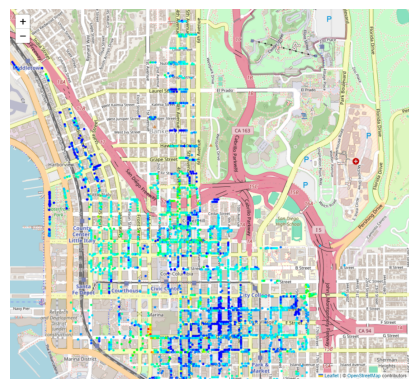

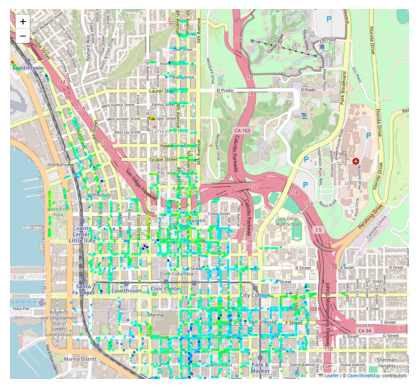

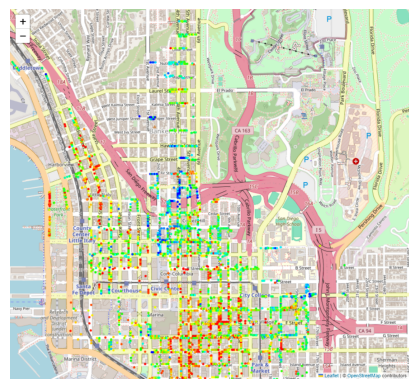

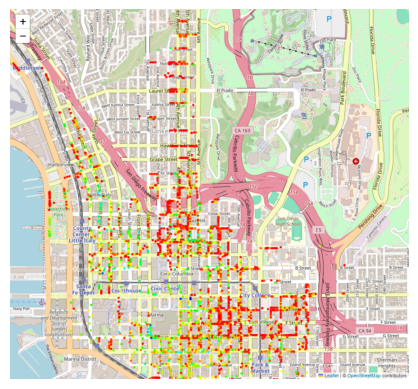

In [120]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of paths to the saved images
image_paths = file_names

# Loop through each image path
for image_path in image_paths:
    # Load the image using matplotlib
    image_path = image_path+".png"
    img = mpimg.imread(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()